In [95]:
pip install ipynb

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [96]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [97]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [98]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [99]:
import sys
print(sys.executable)

/Library/Developer/CommandLineTools/usr/bin/python3


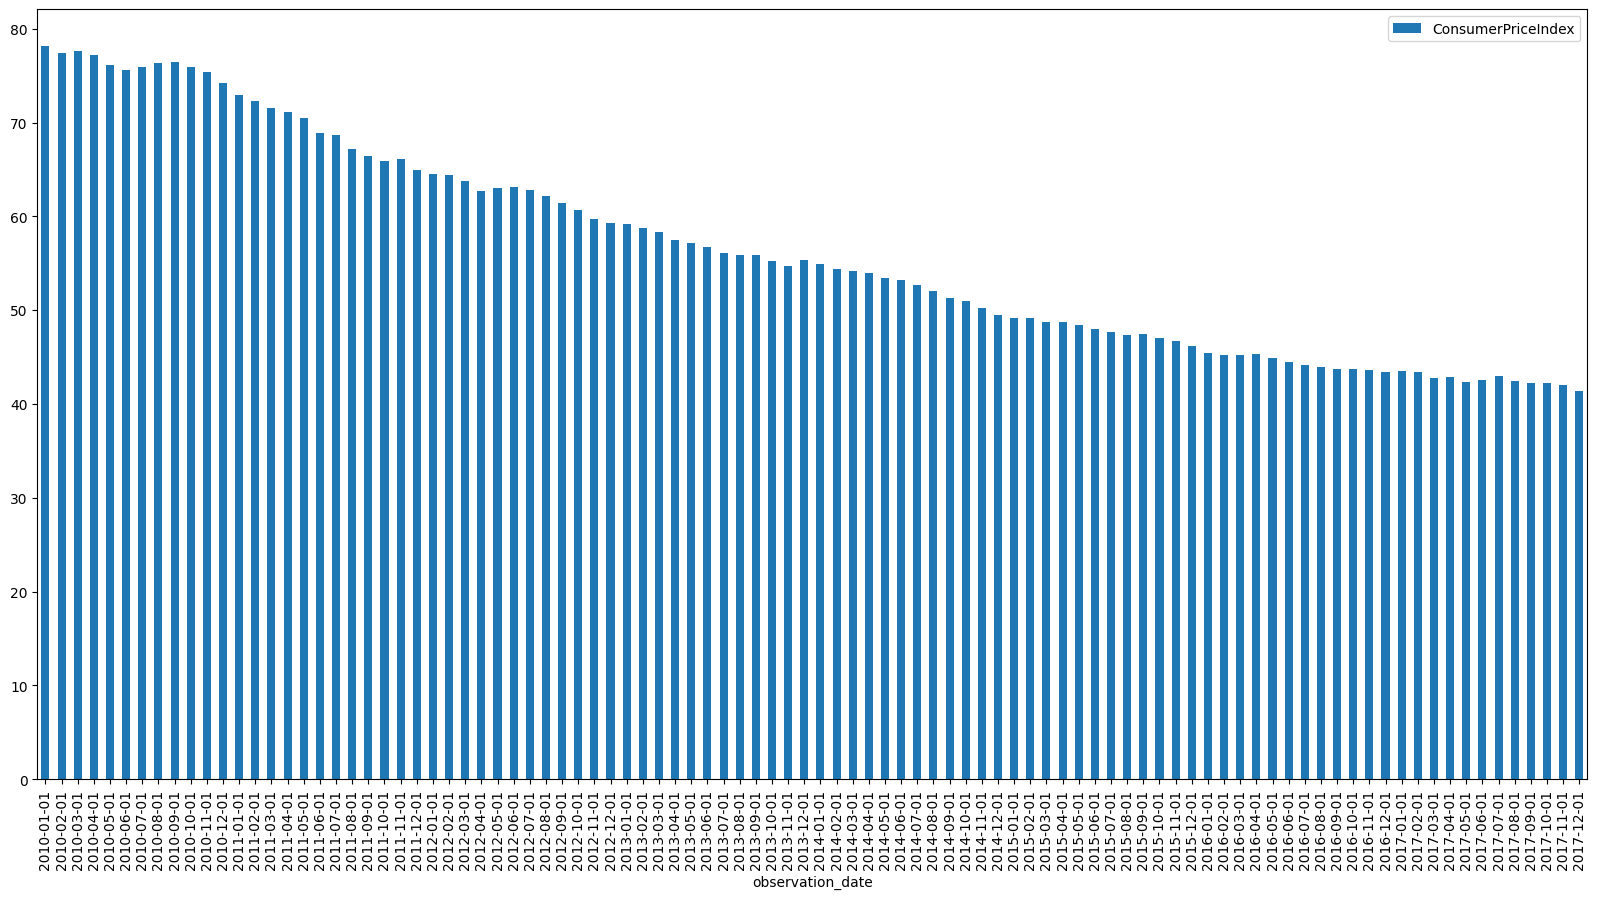

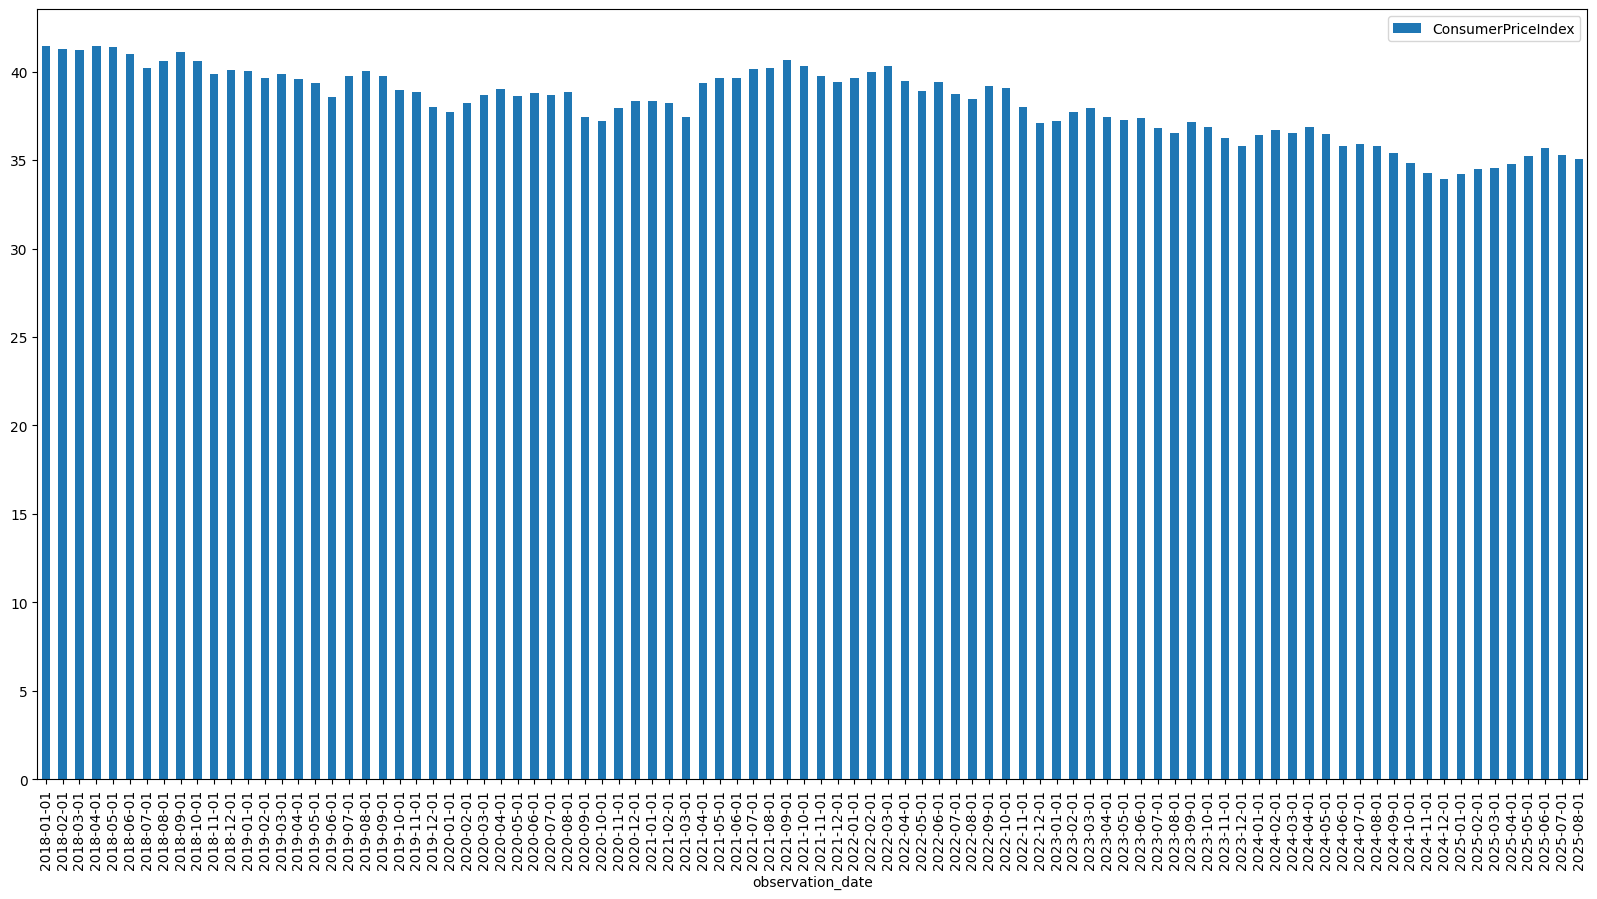

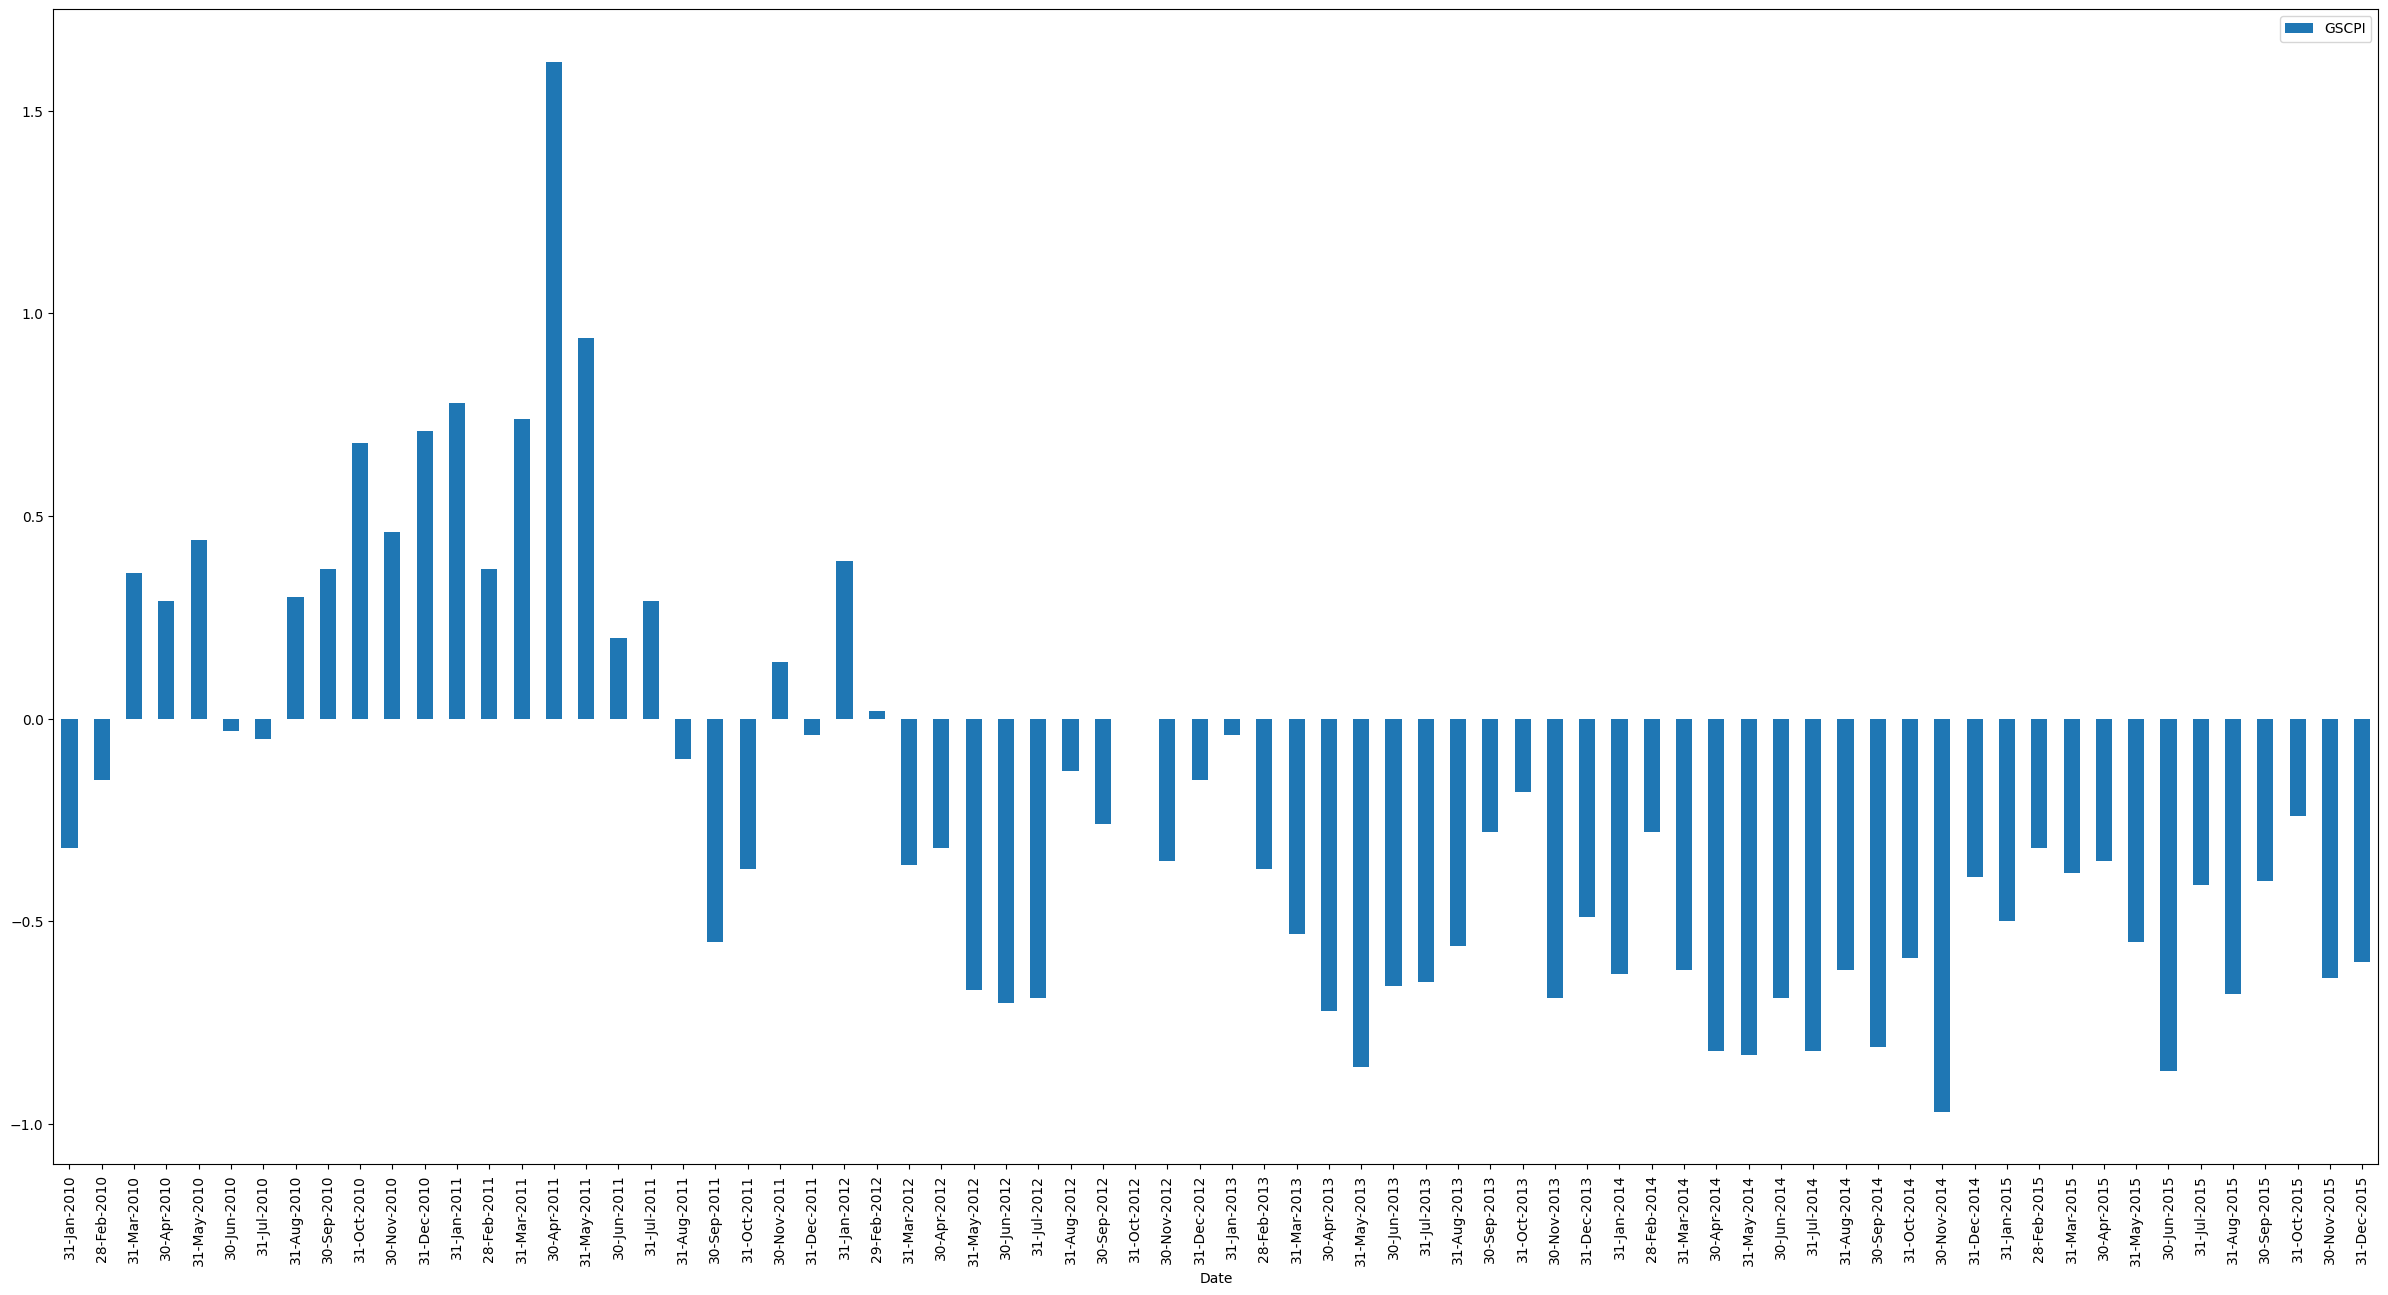

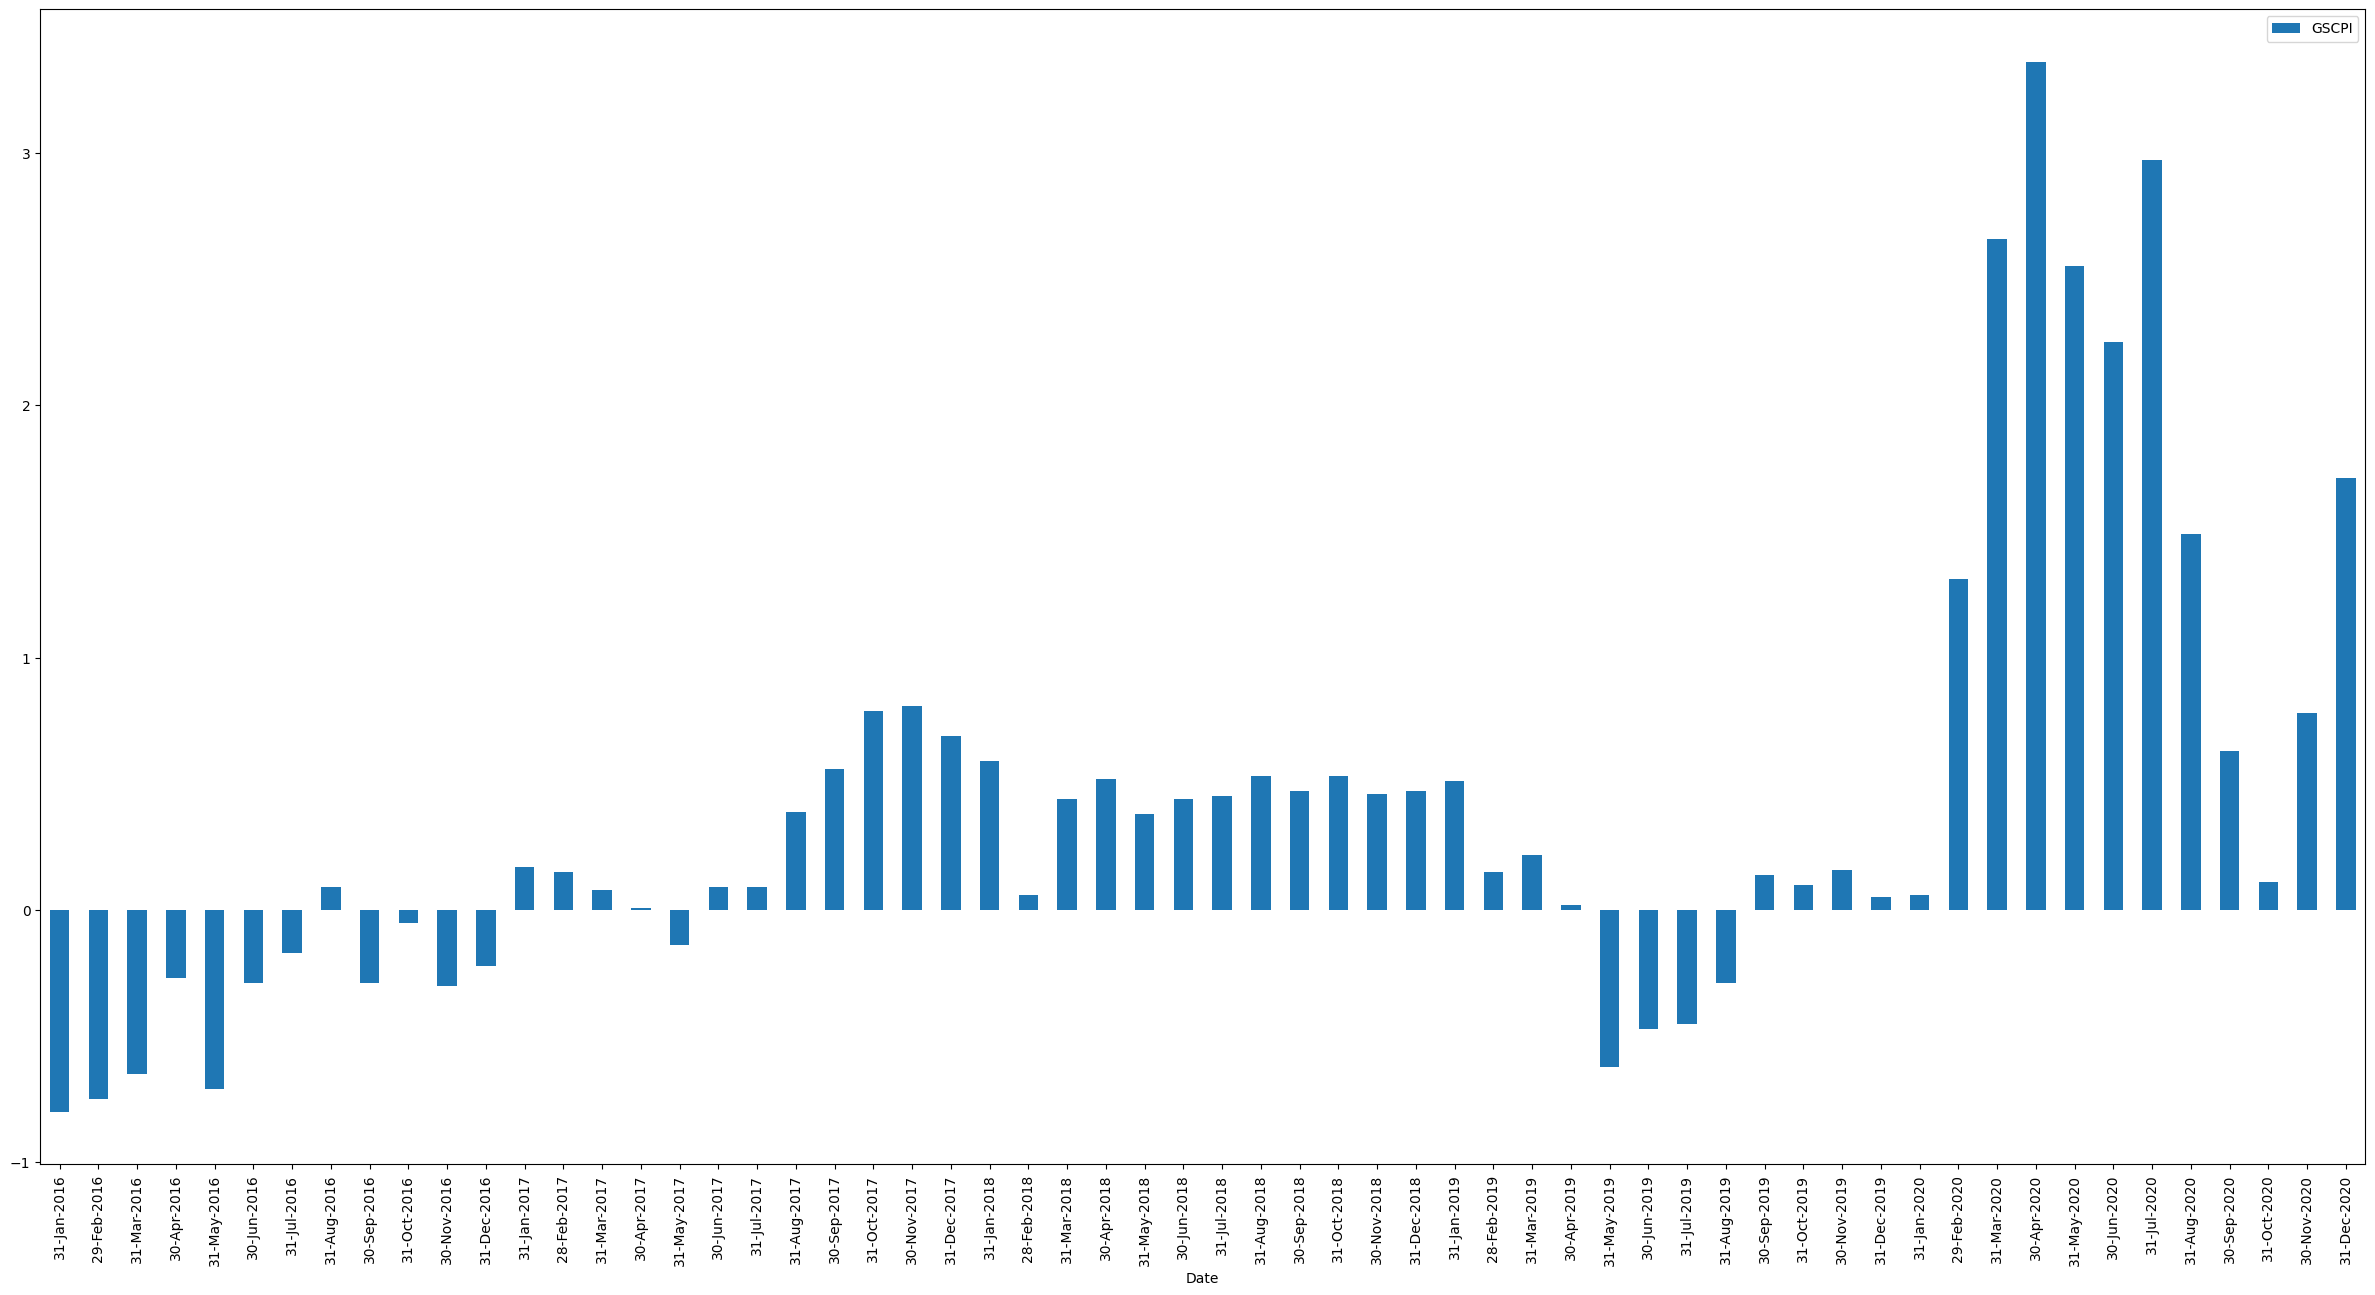

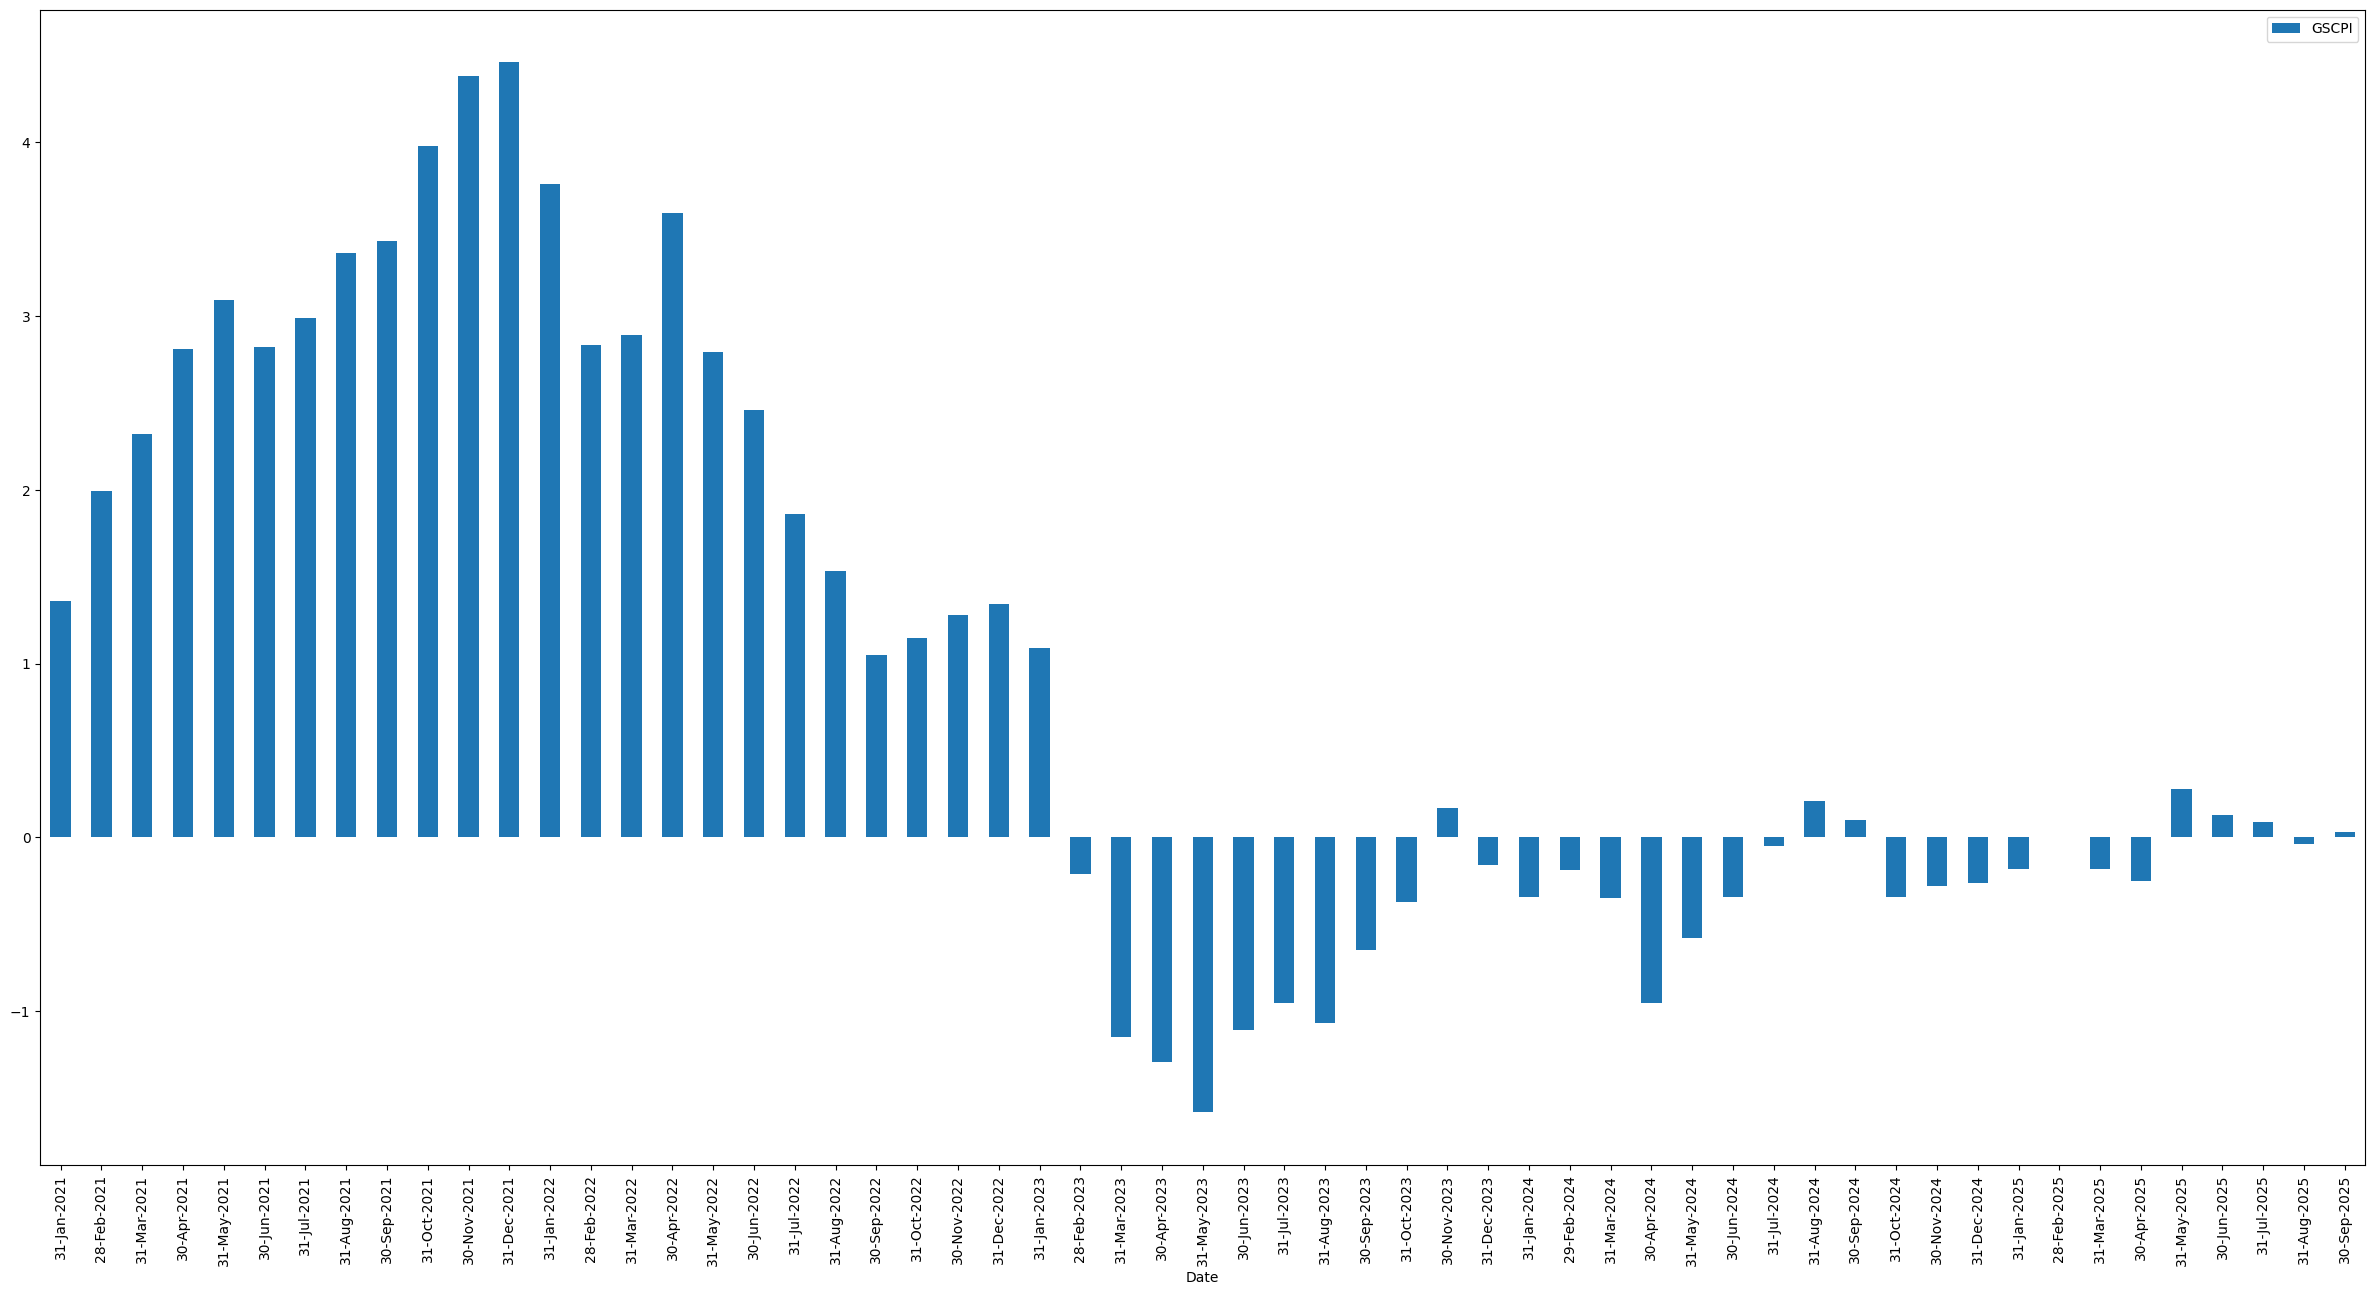

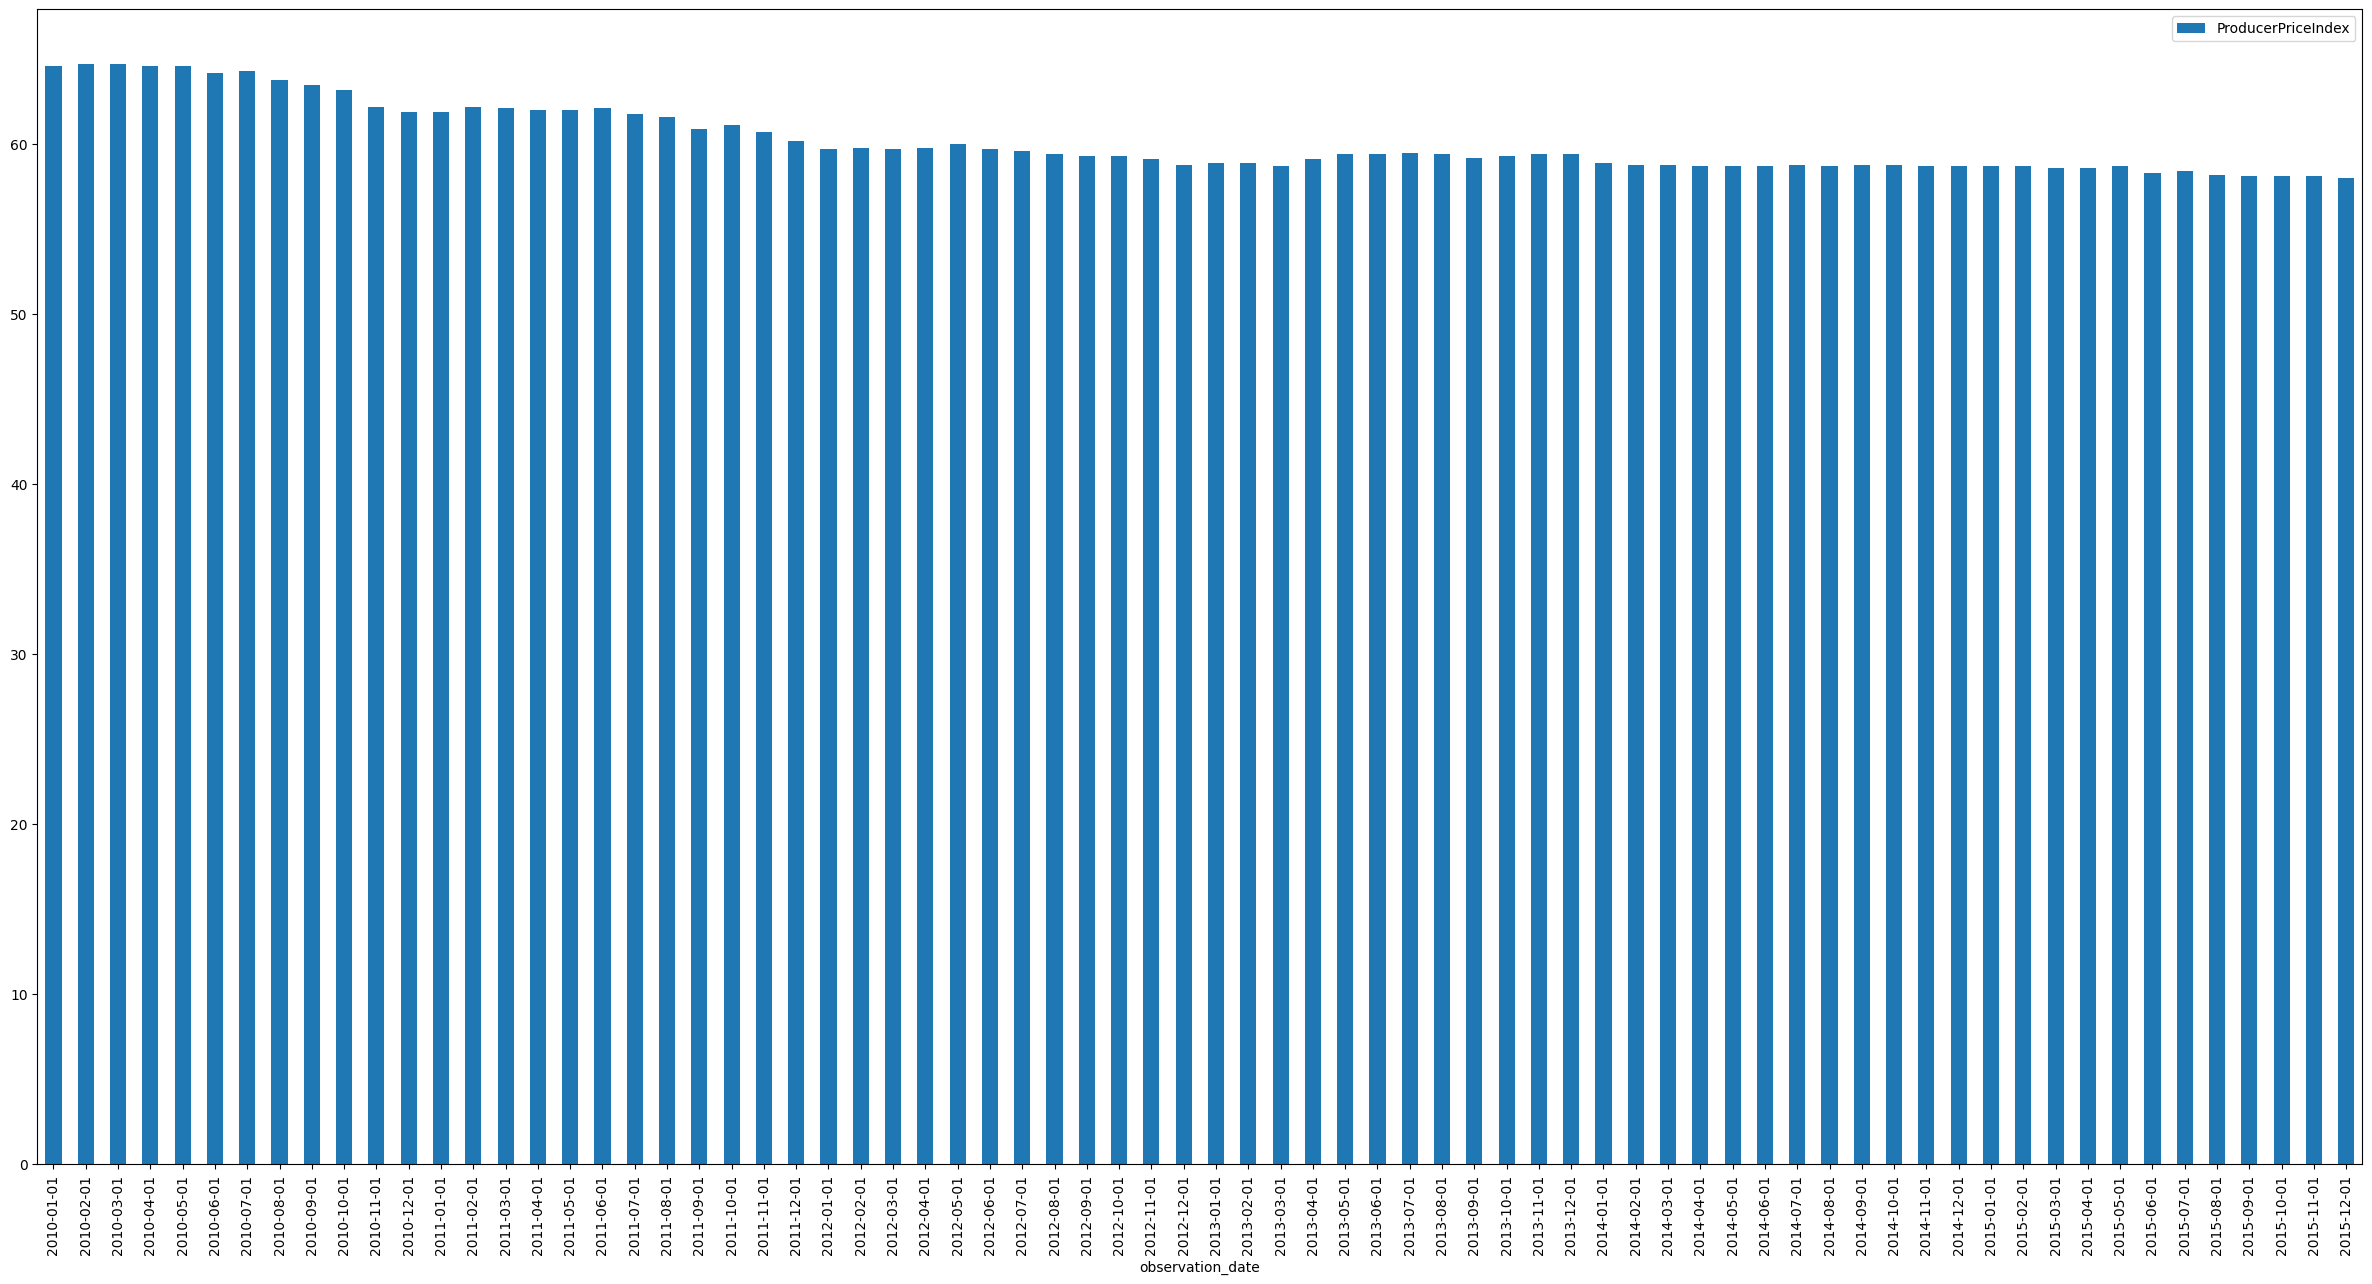

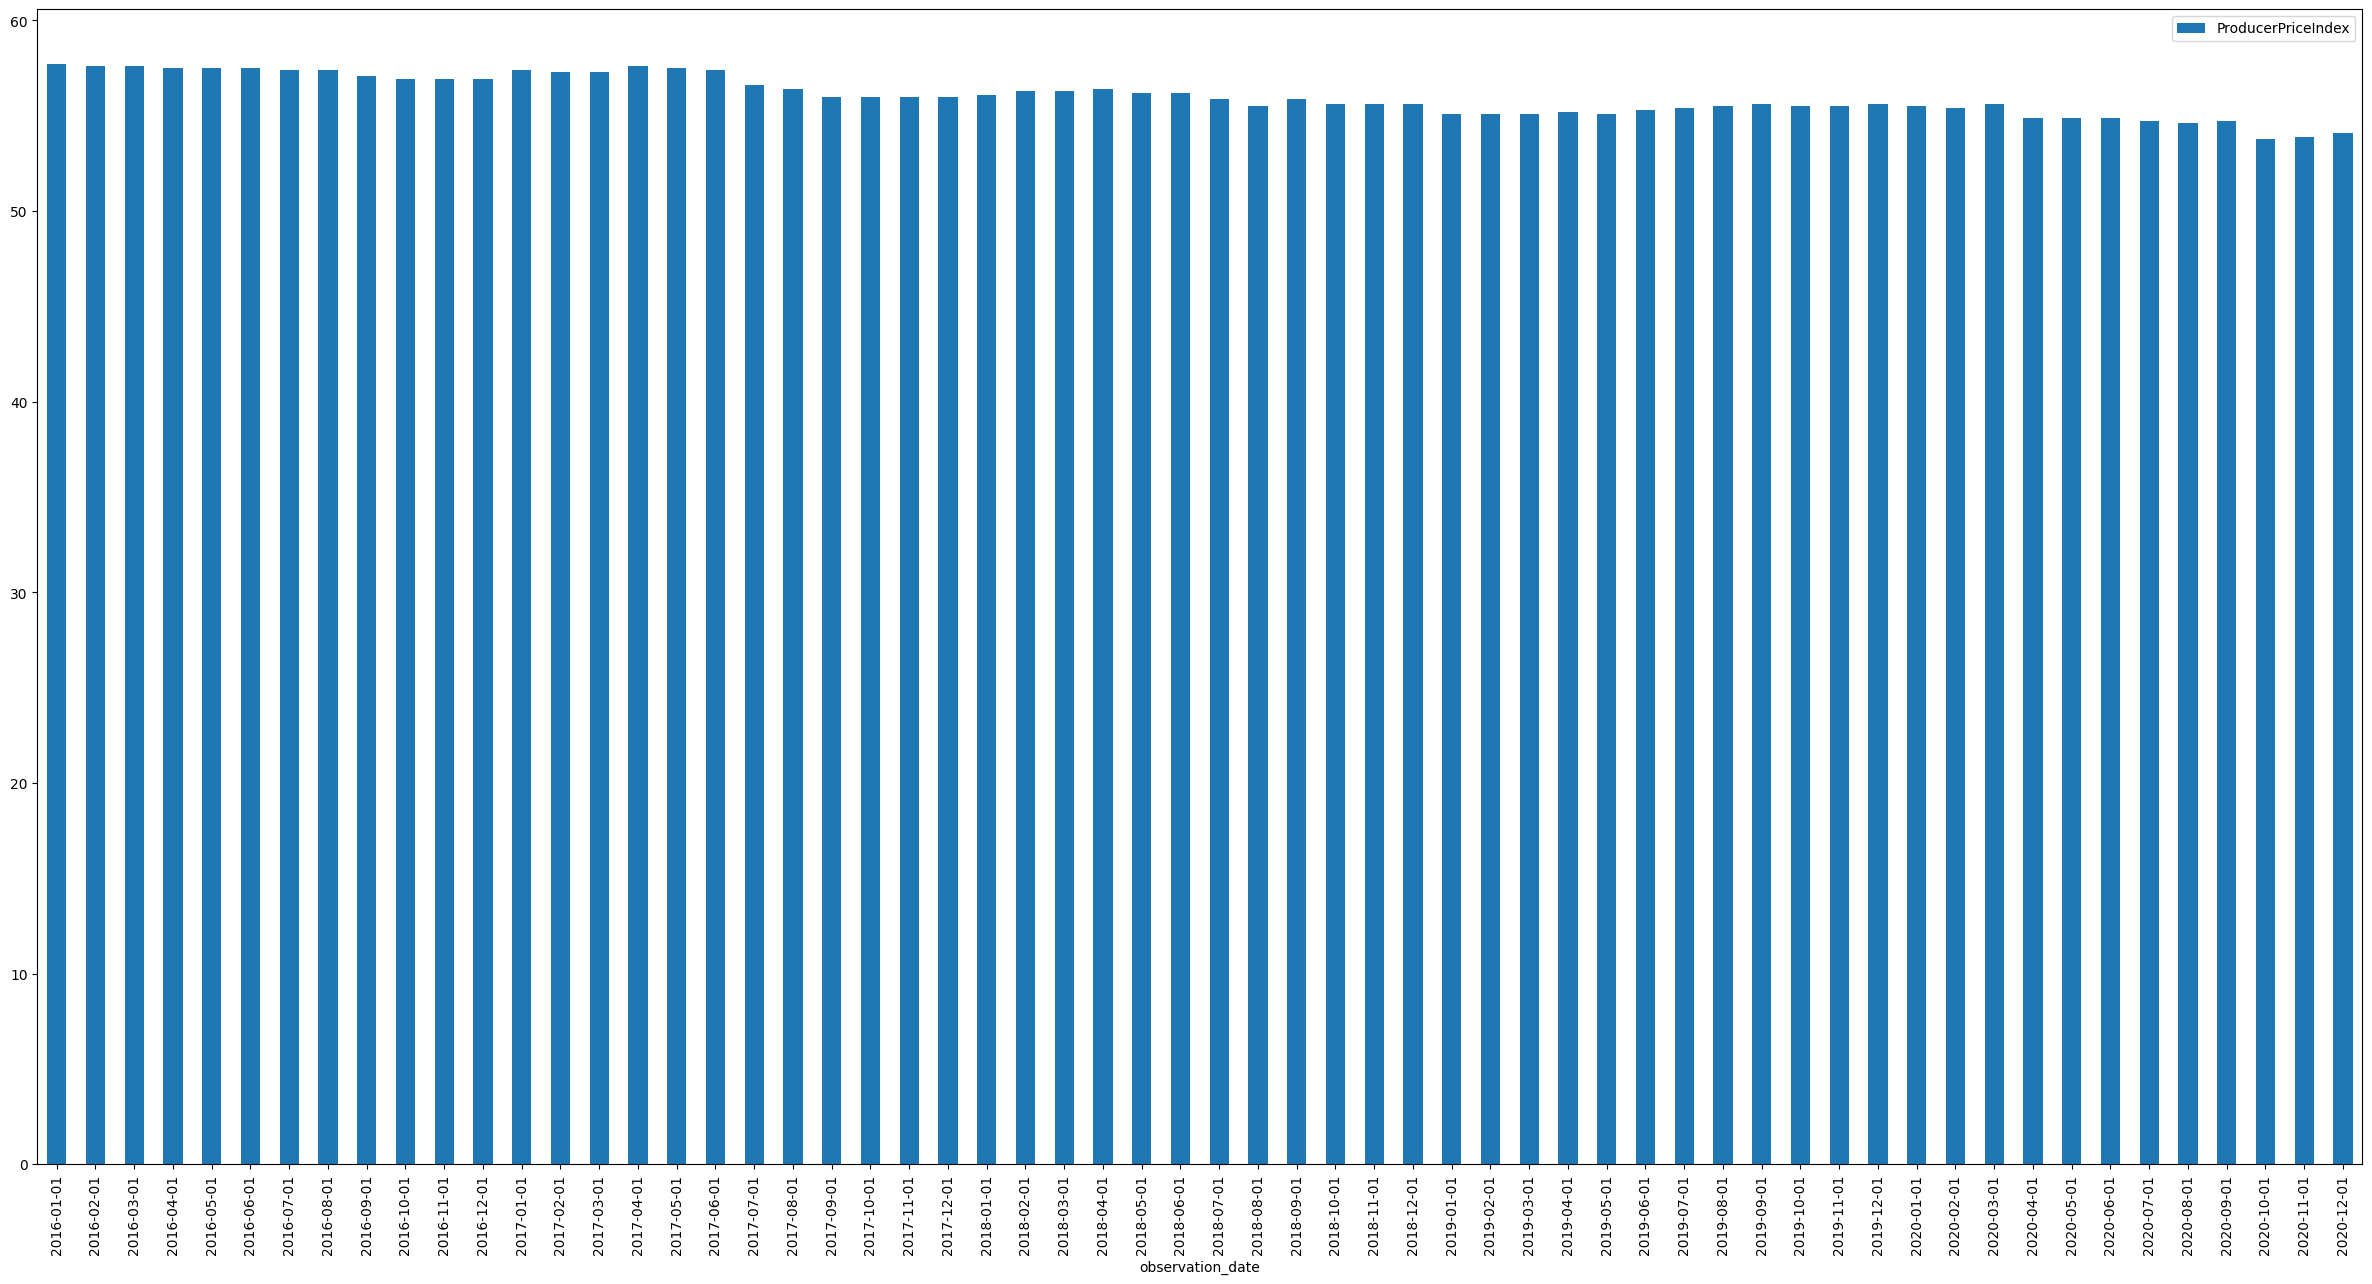

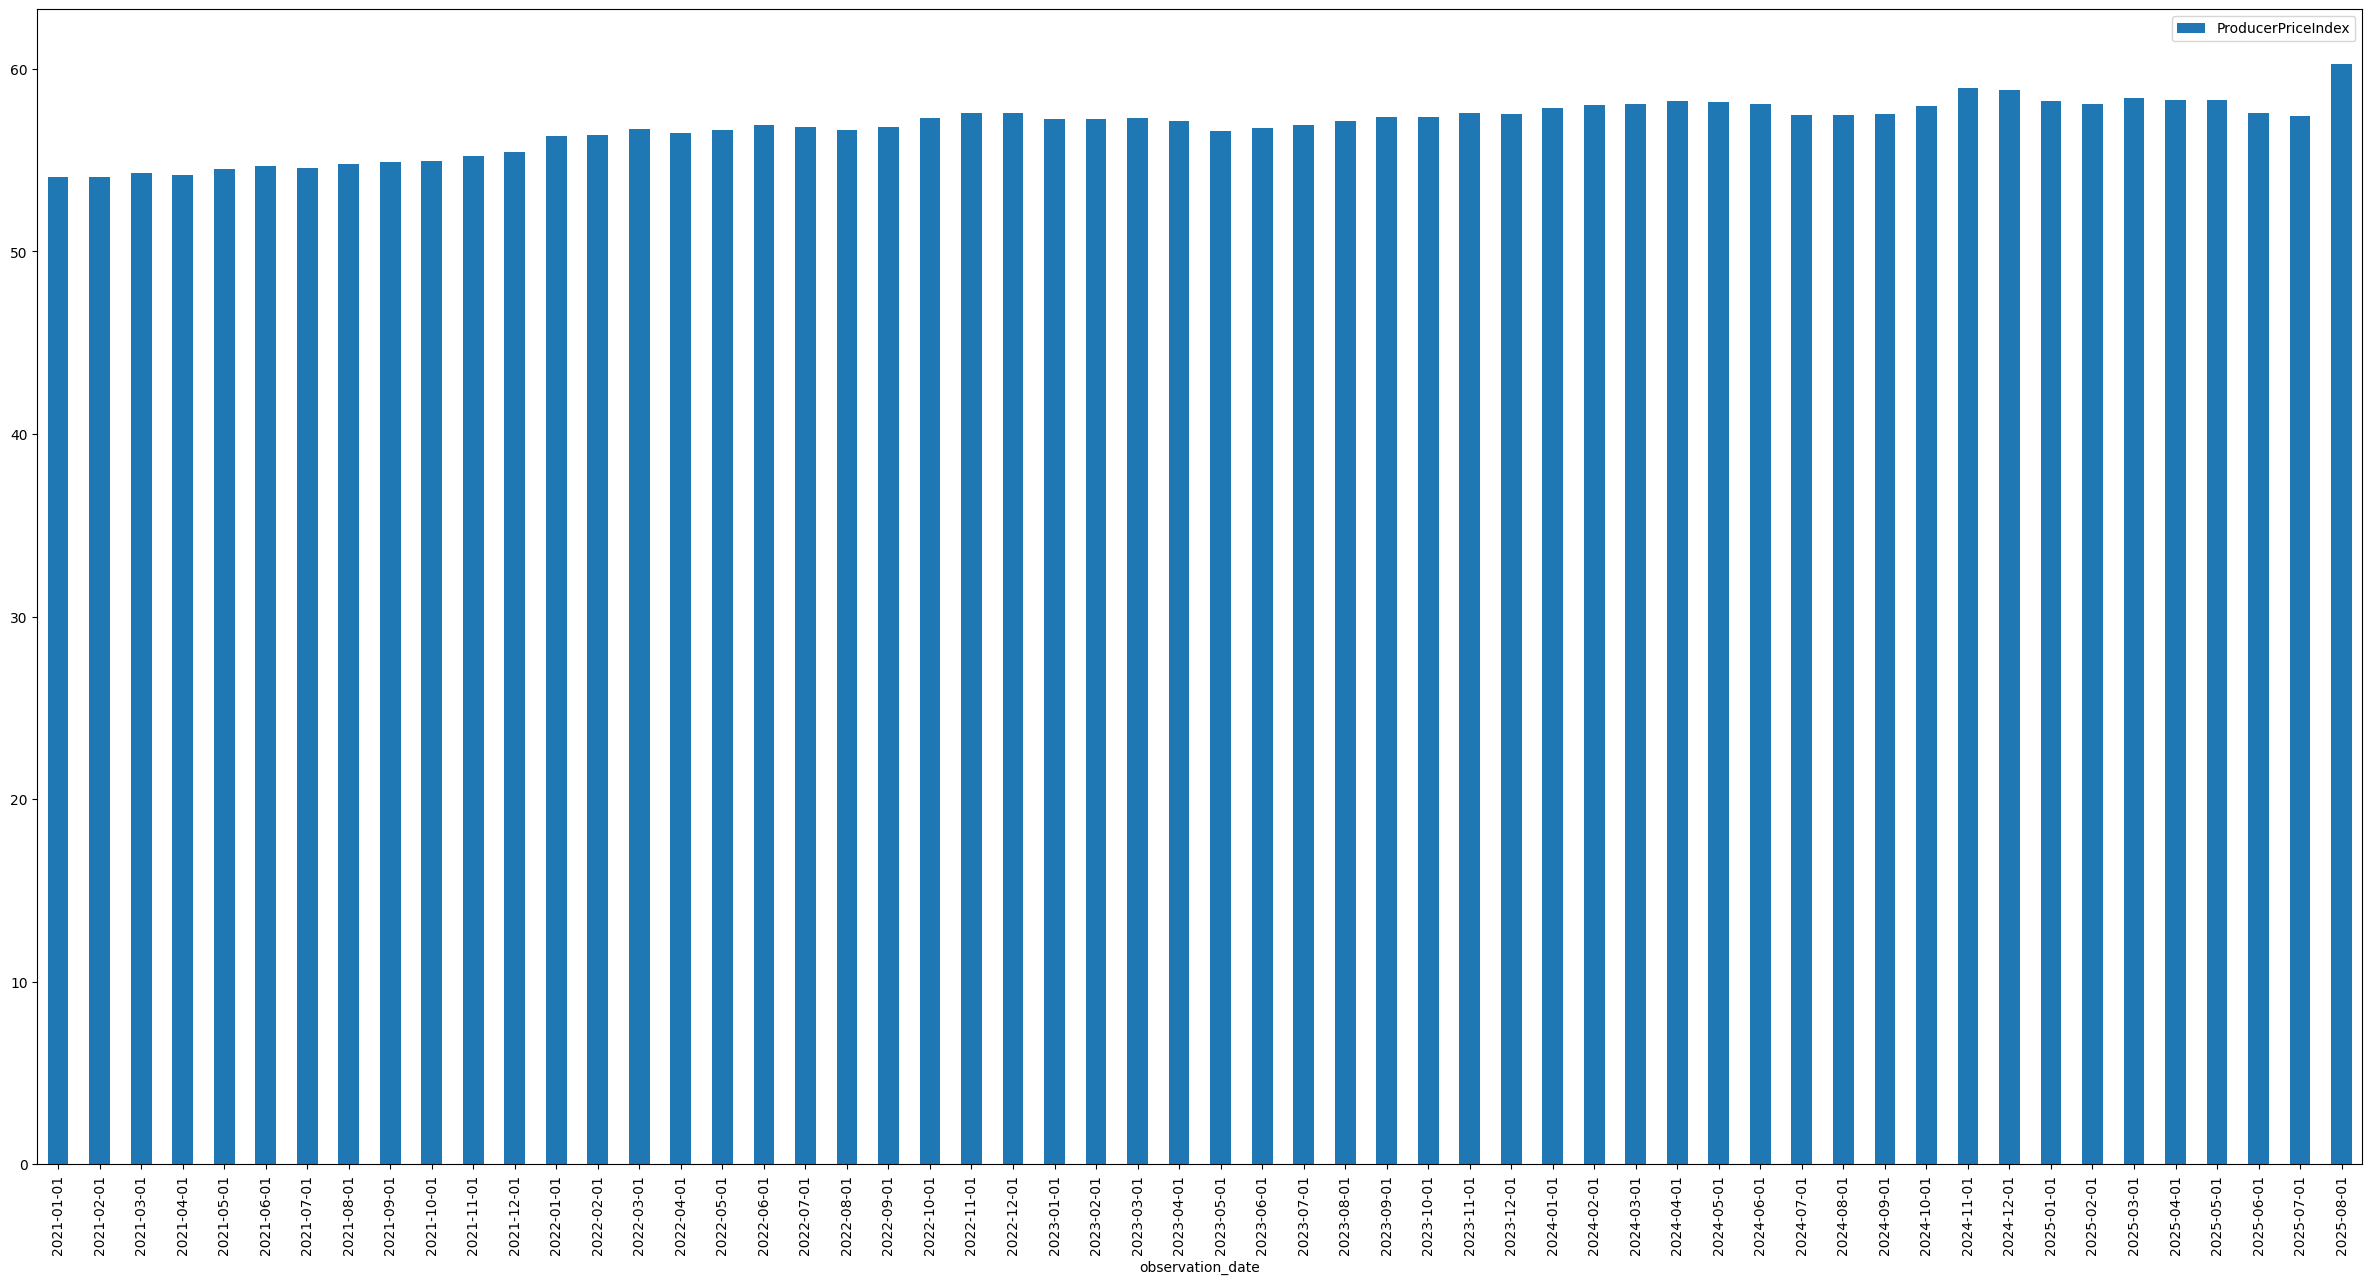

In [100]:
#importing all needed libraries and other notebooks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX

%run ./CPI.ipynb
%run ./GSCPI.ipynb
%run ./PPI.ipynb

import warnings
warnings.filterwarnings("ignore")

In [101]:
from xgboost import XGBRegressor
print("XGBoost loaded successfully!")

XGBoost loaded successfully!


In [102]:
#reading the CPI dataset correctly from 2010
df_C = df_cpi = pd.read_csv("ConsumerPriceIndexforallUrbanConsumers.csv")
df_C.dropna()
df_C.reset_index(drop = True, inplace = True)
df_C.rename(columns={'CUSR0000SEEE01': 'ConsumerPriceIndex'}, inplace=True) 

#reading the GSCPI dataset correctly from 2010
df_1= pd.read_csv("gscpi_data 2.csv")
columns_to_drop = ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4", "Unnamed: 5", "Unnamed: 6", "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10"]
df_globalsupplychain = df_1.drop(columns_to_drop, axis = 1)
df_gscpi = df_globalsupplychain.dropna()
df_gscpi.reset_index(drop = True, inplace = True)

df_new = filterDate_GSCPI(2010)
num = 2011
for i in range(15):
    df2 = filterDate_GSCPI(num)
    df_new = pd.concat([df_new, df2], ignore_index = True)
    num += 1

df_G = df_new
df_G.rename(columns = {"Date" : "observation_date"}, inplace = True)

#reading the PPI dataset correctly from 2010
df_PPI = pd.read_csv("producerPI.csv")
df_PPI.rename(columns={'PCU33443344': 'ProducerPriceIndex'}, inplace=True) 

df_new = filterDate_PPI(2010)
num = 2011
for i in range(15):
    df2 = filterDate_PPI(num)
    df_new = pd.concat([df_new, df2], ignore_index = True)
    num += 1

df_P = df_new

In [103]:
#setting the date correct by making a seperate dataframe for it so everything is uniform
data = []
year = 2010
for i in range(16):
    for i in range(12):
        if i < 9:
            a = "-0" + str(i + 1)
        else:
            a = "-" + str(i + 1)
        date = str(year) + a
        d = {"observation_date" : date}
        data.append(d)
    year +=1

df_Date = pd.DataFrame(data)
df_Date['observation_date'] = pd.to_datetime(df_Date['observation_date'])
df_Date['observation_date'] = df_Date['observation_date'].dt.strftime('%Y%m')
df_Date['observation_date'] = df_Date['observation_date'].astype(int)
df_Date

,observation_date
0,201001
1,201002
2,201003
3,201004
4,201005
...,...
187,202508
188,202509
189,202510
190,202511


In [104]:
#Making the final dataset by combining the supply chain indicators with the observation_date column
df = df_Date
df["GSCPI"] = df_G["GSCPI"]
df["PPI"] = df_P.ProducerPriceIndex
df["CPI"] = df_C.ConsumerPriceIndex
df['InflationRate'] = ((df['CPI'].pct_change() + df['PPI'].pct_change()) / 2) * 100
df = df.dropna(subset=['InflationRate'])
df

,observation_date,GSCPI,PPI,CPI,InflationRate
1,201002,-0.15,64.700,77.450,-0.389472
2,201003,0.36,64.700,77.649,0.128470
3,201004,0.29,64.600,77.154,-0.396022
4,201005,0.44,64.600,76.192,-0.623428
5,201006,-0.03,64.200,75.584,-0.708590
...,...,...,...,...,...
187,202508,-0.04,60.247,35.064,2.148072
188,202509,0.03,NaN,NaN,0.000000
189,202510,NaN,NaN,NaN,0.000000
190,202511,NaN,NaN,NaN,0.000000


In [105]:
# Example: if you have a column 'observation_date' or 'refYear'/'refMonth'
if 'observation_date' in df.columns:
    df['observation_date'] = pd.to_datetime(df['observation_date'], errors='coerce')
elif {'refYear','refMonth'}.issubset(df.columns):
    df['observation_date'] = pd.to_datetime(df[['refYear','refMonth']].assign(day=1))
else:
    raise ValueError("No usable date column found: add 'observation_date' or 'refYear'+'refMonth'")

df = df.set_index('observation_date').sort_index()

In [106]:
# --- Make sure all model columns are numeric ---
cols = ['InflationRate', 'GSCPI', 'PPI', 'CPI']  # adjust if different names
for c in cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Replace inf with NaN and impute sensibly (time-series friendly)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Use forward-fill for short gaps and backfill to cover top edge
df[cols] = df[cols].ffill().bfill()
# Final safety: if any remain, drop rows that still have NaN in target or exog
df = df.dropna(subset=['InflationRate','GSCPI','PPI'])
print("After cleaning, rows:", len(df))

After cleaning, rows: 191


In [107]:
# Create lag features for main predictors
lags = [1, 2, 3, 6, 12]

for col in ["GSCPI", "PPI", "InflationRate"]:
    for lag in lags:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)

# Rolling mean and volatility
df["Inflation_3m_mean"] = df["InflationRate"].rolling(3).mean()
df["Inflation_6m_vol"] = df["InflationRate"].rolling(6).std()

df = df.dropna()
df.head()

,GSCPI,PPI,CPI,InflationRate,GSCPI_lag1,GSCPI_lag2,GSCPI_lag3,GSCPI_lag6,GSCPI_lag12,PPI_lag1,...,PPI_lag3,PPI_lag6,PPI_lag12,InflationRate_lag1,InflationRate_lag2,InflationRate_lag3,InflationRate_lag6,InflationRate_lag12,Inflation_3m_mean,Inflation_6m_vol
observation_date,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000201102,0.37,62.2,72.287,-0.205981,0.78,0.71,0.46,0.30,-0.15,61.9,...,62.2,63.8,64.7,-0.834468,-1.037788,-1.120607,-0.126640,-0.389472,-0.692746,0.417269
1970-01-01 00:00:00.000201103,0.74,62.1,71.509,-0.618519,0.37,0.78,0.71,0.37,0.36,62.2,...,61.9,63.5,64.7,-0.205981,-0.834468,-1.037788,-0.133544,0.128470,-0.552989,0.334032
1970-01-01 00:00:00.000201104,1.62,62.0,71.106,-0.362298,0.74,0.37,0.78,0.68,0.29,62.1,...,61.9,63.2,64.6,-0.618519,-0.205981,-0.834468,-0.615504,-0.396022,-0.395599,0.367086
1970-01-01 00:00:00.000201105,0.94,62.0,70.499,-0.426828,1.62,0.74,0.37,0.46,0.44,62.0,...,62.2,62.2,64.6,-0.362298,-0.618519,-0.205981,-1.120607,-0.623428,-0.469215,0.311945
1970-01-01 00:00:00.000201106,0.20,62.1,68.854,-1.086038,0.94,1.62,0.74,0.71,-0.03,62.0,...,62.1,61.9,64.2,-0.426828,-0.362298,-0.618519,-1.037788,-0.708590,-0.625055,0.326365


In [108]:
# 4. Select features used for clustering/model
# ===========================================

feature_cols = [
    "GSCPI", "PPI", 
    "GSCPI_lag1", "GSCPI_lag2", "GSCPI_lag3",
    "PPI_lag1", "PPI_lag2", "PPI_lag3",
    "InflationRate_lag1", "InflationRate_lag2", "InflationRate_lag3",
    "Inflation_3m_mean", "Inflation_6m_vol"
]

X = df[feature_cols]
y = df["InflationRate"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature shape:", X_scaled.shape)

Scaled feature shape: (179, 13)


In [109]:
# 5. Use KMeans to find economic regimes
# ======================================

# We can adjust k between 2–4
k = 3  

kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df["cluster"] = clusters

df["cluster"].value_counts()

cluster
0    77
2    70
1    32
Name: count, dtype: int64

In [110]:
# 6. Train a separate model for each cluster (XGBoost or RF)
# ==========================================================

cluster_models = {}

for c in df["cluster"].unique():
    
    cluster_data = df[df["cluster"] == c]
    
    X_c = cluster_data[feature_cols]
    y_c = cluster_data["InflationRate"]
    
    # Choose model based on cluster size
    if len(cluster_data) > 100:
        model = XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
    else:
        model = RandomForestRegressor(
            n_estimators=150,
            max_depth=5,
            random_state=42
        )
        
    model.fit(X_c, y_c)
    cluster_models[c] = model

cluster_models

{np.int32(2): RandomForestRegressor(max_depth=5, n_estimators=150, random_state=42),
 np.int32(0): RandomForestRegressor(max_depth=5, n_estimators=150, random_state=42),
 np.int32(1): RandomForestRegressor(max_depth=5, n_estimators=150, random_state=42)}

In [111]:
# 7. Rolling cross-validation prediction with clustering
# ======================================================

def predict_with_clusters(X_window):
    """Assign a cluster + use its model to predict."""
    X_scaled_window = scaler.transform([X_window])[0]
    cluster = kmeans.predict([X_scaled_window])[0]
    model = cluster_models[cluster]
    return model.predict([X_window])[0]


# Rolling forecast evaluation
preds = []
actuals = []

window = 60  # 60 months training window

for i in range(window, len(df)):
    
    # Actual inflation for evaluation
    actual = y.iloc[i]
    
    # Features for this prediction
    X_input = X.iloc[i]
    
    pred = predict_with_clusters(X_input)
    
    preds.append(pred)
    actuals.append(actual)


mae = mean_absolute_error(actuals, preds)
rmse = np.sqrt(mean_squared_error(actuals, preds))

mae, rmse

(0.18984812044876917, np.float64(0.2469622451157922))

In [112]:
# 8. Bias correction per cluster (important!)
# ===================================================

bias = {}

for c in df["cluster"].unique():
    subset = df[df["cluster"] == c]
    model = cluster_models[c]
    
    errors = subset["InflationRate"] - model.predict(subset[feature_cols])
    bias[c] = errors.mean()

bias

{np.int32(2): np.float64(0.0020657079590160545),
 np.int32(0): np.float64(-0.011669487631648379),
 np.int32(1): np.float64(0.017942271366297148)}

In [113]:
# 9. Apply bias correction + compute final MAE/RMSE
# ===============================================================

corrected_preds = []
actuals = []

for i in range(window, len(df)):
    
    X_input = X.iloc[i]
    actual = y.iloc[i]
    
    # Predict cluster and raw estimate
    X_scaled_window = scaler.transform([X_input])[0]
    cluster = kmeans.predict([X_scaled_window])[0]
    
    raw_pred = cluster_models[cluster].predict([X_input])[0]
    corrected_pred = raw_pred - bias[cluster]
    
    corrected_preds.append(corrected_pred)
    actuals.append(actual)

mae_corr = mean_absolute_error(actuals, corrected_preds)
rmse_corr = np.sqrt(mean_squared_error(actuals, corrected_preds))

mae_corr, rmse_corr

(0.190219023360784, np.float64(0.24806739510161419))

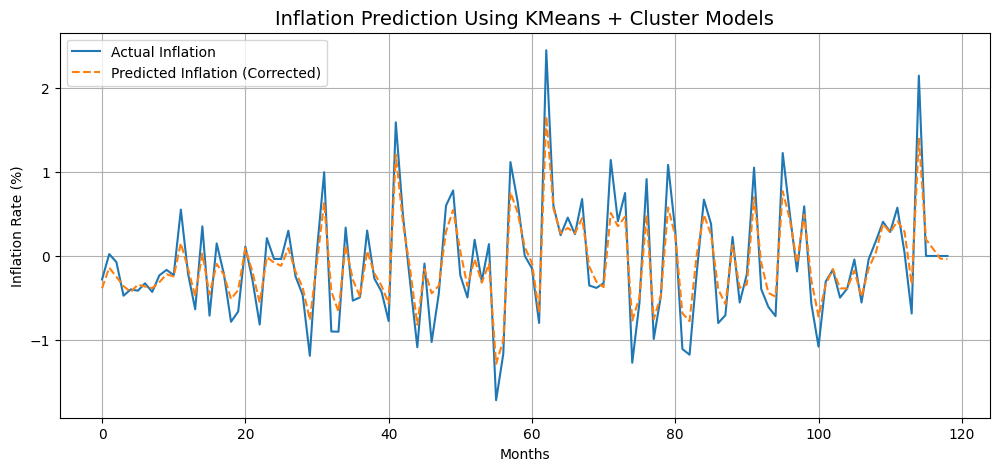

In [114]:
# 10. Plot Actual vs Predicted Inflation
# ===================================================

plt.figure(figsize=(12,5))
plt.plot(actuals, label="Actual Inflation")
plt.plot(corrected_preds, label="Predicted Inflation (Corrected)", linestyle="--")
plt.title("Inflation Prediction Using KMeans + Cluster Models", fontsize=14)
plt.xlabel("Months")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.grid(True)
plt.show()

                               SARIMAX Results                                
Dep. Variable:          InflationRate   No. Observations:                  173
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -148.721
Date:                Thu, 13 Nov 2025   AIC                            307.442
Time:                        22:35:55   BIC                            323.121
Sample:                             0   HQIC                           313.804
                                - 173                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PPI_lag1      -0.0886      0.041     -2.157      0.031      -0.169      -0.008
GSCPI_lag1     0.0153      0.040      0.381      0.703      -0.063       0.094
ar.L1          0.0404      0.086      0.470      0.6

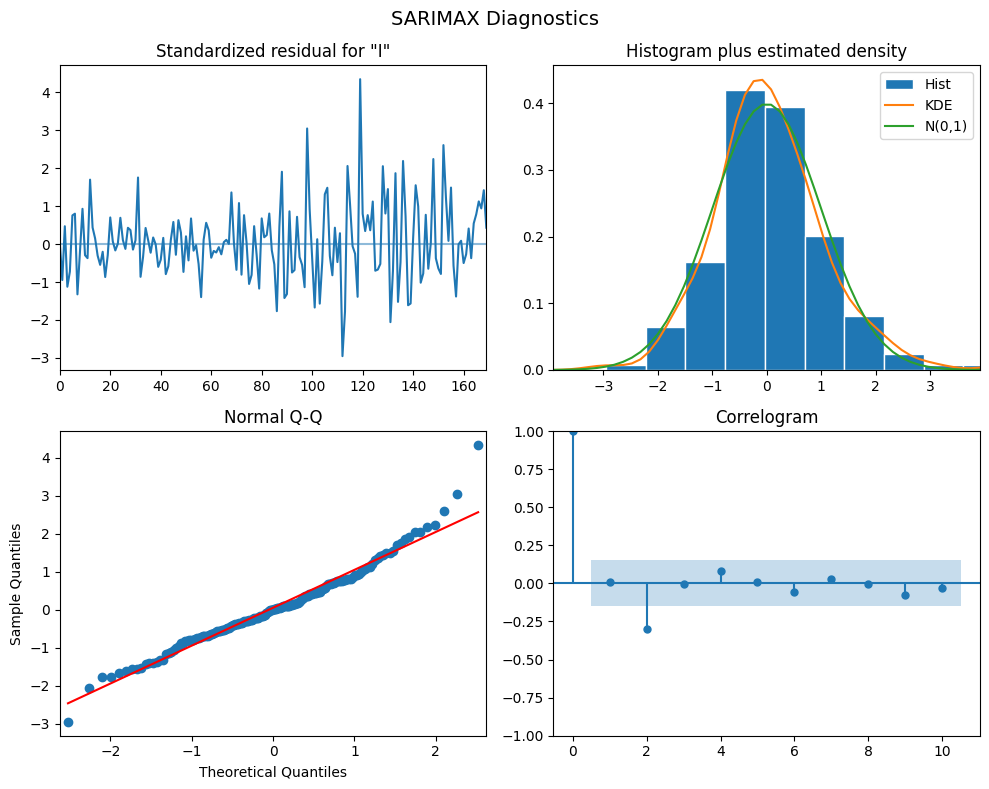

In [115]:
# --- Fit SARIMAX ---
model = SARIMAX(y_train, exog = X_train, order=(1,1,1), enforce_stationarity = False, enforce_invertibility = False)
fit = model.fit(disp = False)
print(fit.summary())
fit.plot_diagnostics(figsize=(10,8))
plt.suptitle("SARIMAX Diagnostics", fontsize=14)
plt.tight_layout()

In [116]:
# --- Train / test split ---
forecast_steps = 6
if len(df) <= forecast_steps + 12:
    raise ValueError(f"Not enough data ({len(df)} rows) for forecast_steps={forecast_steps} + minimal training window.")

train = df.iloc[:-forecast_steps]
test  = df.iloc[-forecast_steps:]

# Target
y_train = train['InflationRate'].squeeze()

# Use lagged exog variables (example: choose first lag of each)
exog_cols = ['PPI_lag1', 'GSCPI_lag1']  # start simple; you can expand
X_train = train[exog_cols]
X_test  = test[exog_cols]

# Quick sanity checks
print("y_train shape:", y_train.shape)
print("X_train shape:", X_train.shape)
assert len(y_train) == X_train.shape[0], "Mismatch between y_train and X_train lengths"

y_train shape: (173,)
X_train shape: (173, 2)


In [117]:
#Finding Correlation Coefficient between GSCPI and CPI
df.corr()["GSCPI"]["CPI"]

np.float64(-0.2561559110093105)

In [118]:
#Finding Correlation Coefficient between CPI and PPI
df.corr()["CPI"]["PPI"]

np.float64(0.7062116652906527)

In [119]:
#Finding Correlation Coefficient between GSCPI and PPI
df.corr()["GSCPI"]["PPI"]

np.float64(-0.49602671505417884)

In [120]:
df

,GSCPI,PPI,CPI,InflationRate,GSCPI_lag1,GSCPI_lag2,GSCPI_lag3,GSCPI_lag6,GSCPI_lag12,PPI_lag1,...,PPI_lag6,PPI_lag12,InflationRate_lag1,InflationRate_lag2,InflationRate_lag3,InflationRate_lag6,InflationRate_lag12,Inflation_3m_mean,Inflation_6m_vol,cluster
observation_date,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.000201102,0.37,62.200,72.287,-0.205981,0.78,0.71,0.46,0.30,-0.15,61.900,...,63.800,64.700,-0.834468,-1.037788,-1.120607,-0.126640,-0.389472,-0.692746,0.417269,2
1970-01-01 00:00:00.000201103,0.74,62.100,71.509,-0.618519,0.37,0.78,0.71,0.37,0.36,62.200,...,63.500,64.700,-0.205981,-0.834468,-1.037788,-0.133544,0.128470,-0.552989,0.334032,2
1970-01-01 00:00:00.000201104,1.62,62.000,71.106,-0.362298,0.74,0.37,0.78,0.68,0.29,62.100,...,63.200,64.600,-0.618519,-0.205981,-0.834468,-0.615504,-0.396022,-0.395599,0.367086,2
1970-01-01 00:00:00.000201105,0.94,62.000,70.499,-0.426828,1.62,0.74,0.37,0.46,0.44,62.000,...,62.200,64.600,-0.362298,-0.618519,-0.205981,-1.120607,-0.623428,-0.469215,0.311945,2
1970-01-01 00:00:00.000201106,0.20,62.100,68.854,-1.086038,0.94,1.62,0.74,0.71,-0.03,62.000,...,61.900,64.200,-0.426828,-0.362298,-0.618519,-1.037788,-0.708590,-0.625055,0.326365,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000202508,-0.04,60.247,35.064,2.148072,0.09,0.13,0.28,-0.00,0.21,57.439,...,58.059,57.484,-0.685848,0.039585,0.575465,0.177140,-0.163675,0.500603,0.936551,0
1970-01-01 00:00:00.000202509,0.03,60.247,35.064,0.000000,-0.04,0.09,0.13,-0.18,0.10,60.247,...,58.414,57.533,2.148072,-0.685848,0.039585,0.407240,-0.496606,0.487408,0.955851,0
1970-01-01 00:00:00.000202510,0.03,60.247,35.064,0.000000,0.03,-0.04,0.09,-0.25,-0.34,60.247,...,58.312,57.992,0.000000,2.148072,-0.685848,0.286097,-0.387688,0.716024,0.969345,0


                               SARIMAX Results                                
Dep. Variable:          InflationRate   No. Observations:                  173
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -148.721
Date:                Thu, 13 Nov 2025   AIC                            307.442
Time:                        22:35:55   BIC                            323.121
Sample:                             0   HQIC                           313.804
                                - 173                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PPI_lag1      -0.0886      0.041     -2.157      0.031      -0.169      -0.008
GSCPI_lag1     0.0153      0.040      0.381      0.703      -0.063       0.094
ar.L1          0.0404      0.086      0.470      0.6

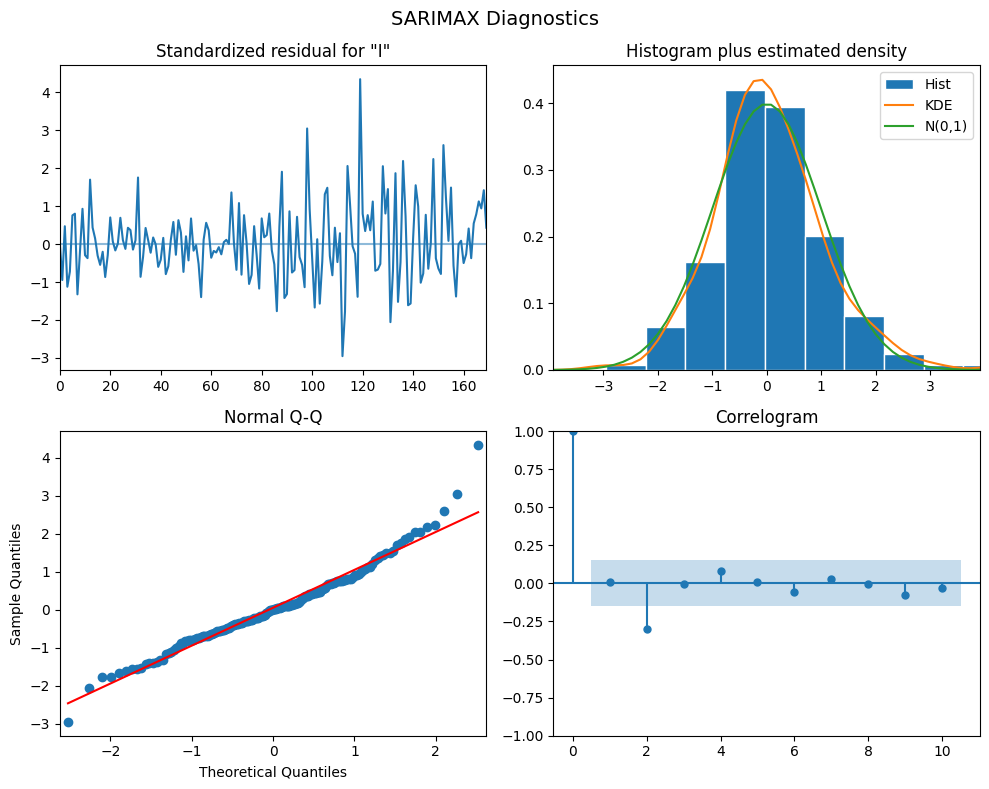

In [121]:
# --- Fit SARIMAX ---
model = SARIMAX(y_train, exog = X_train, order=(1,1,1), enforce_stationarity = False, enforce_invertibility = False)
fit = model.fit(disp = False)
print(fit.summary())
fit.plot_diagnostics(figsize=(10,8))
plt.suptitle("SARIMAX Diagnostics", fontsize=14)
plt.tight_layout()

Standardized residuals time series (TOP LEFT GRAPH):

WHAT IT SHOWS:
This is the residuals series (model errors) scaled by their estimated standard deviation. It’s the sequence:
standardized_resid[t] = (observed_t - fitted_t) / sigma_hat
plotted versus time.

HEALTHY RESULT:
Residuals should hover randomly around zero with no obvious trend or pattern.
Variability should be roughly constant over time (no systematic increase/decrease).
No long runs of positive or negative residuals (no persistent bias).

WHY IT MATTERS:
If residuals show structure (trend, cycles, seasonal patterns) the model is missing dynamics — it’s not capturing something the data contains. If variance changes over time, the model’s assumption of constant error variance (homoscedasticity) is violated.

Histogram + KDE of standardized residuals (TOP RIGHT GRAPH):

WHAT IT SHOWS: 
A histogram of the standardized residuals with a kernel density estimate (smooth curve) and usually a normal distribution curve overlaid for comparison.

HEALTHY RESULT:
The residual distribution should be approximately normal (bell-shaped) centered at 0.
No extreme skew (asymmetry) or heavy tails (excess kurtosis).

WHY IT MATTERS:
SARIMAX (and the confidence intervals it reports) assume that errors are normally distributed. Large deviations mean your confidence intervals and hypothesis tests may be unreliable.

Normal Q–Q plot (Quantile-Quantile) (BOTTOM LEFT)

WHAT IT SHOWS:
Each point plots the empirical quantiles of the standardized residuals against the theoretical quantiles of a standard normal distribution. A 45° reference line is drawn.

HEALTHY RESULT:
Points lie close to the reference line across the whole range, including the tails. Small deviations near the center are acceptable.

WHY IT MATTERS:
QQ is a more sensitive visual test for departures from normality, especially in the tails. Deviations at the extremes indicate heavier or lighter tails than Normal.

Correlogram / ACF of residuals (BOTTOM RIGHT)

WHAT IT SHOWS:
Autocorrelation Function (ACF) of the residuals plotted for a set number of lags, with confidence bands (usually ±1.96/√N). Each bar shows correlation at lag k.

HEALTHY RESULT:
Most bars lie within the confidence bands (i.e., not statistically significant).
No systematic decay pattern (which would indicate remaining AR behavior). Ideally residual autocorrelations are effectively zero at all lags.

WHY IT MATTERS:
If residuals are autocorrelated, your model has not captured all the time-dependence. Autocorrelation means forecasts are biased and standard errors are wrong.

In [122]:
# --- Prepare future_inputs: use X_test if you have actual future exog for test horizon ---
# If X_test exists and length == forecast_steps, use it; otherwise build from hold-last or trend
if X_test.shape[0] == forecast_steps:
    future_inputs = X_test.copy()
else:
    # Hold-last strategy (simple baseline)
    future_inputs = pd.DataFrame([X_train.iloc[-1].values] * forecast_steps,
                                 columns=X_train.columns,
                                 index=pd.date_range(start=test.index[0], periods=forecast_steps, freq='MS'))

print("future_inputs shape:", future_inputs.shape, "expected:", (forecast_steps, X_train.shape[1]))

# Forecast
forecast_res = fit.get_forecast(steps = forecast_steps, exog = future_inputs)
pred_mean = forecast_res.predicted_mean
pred_ci = forecast_res.conf_int()

# Align index for plotting
pred_mean.index = future_inputs.index
pred_ci.index = future_inputs.index

future_inputs shape: (6, 2) expected: (6, 2)


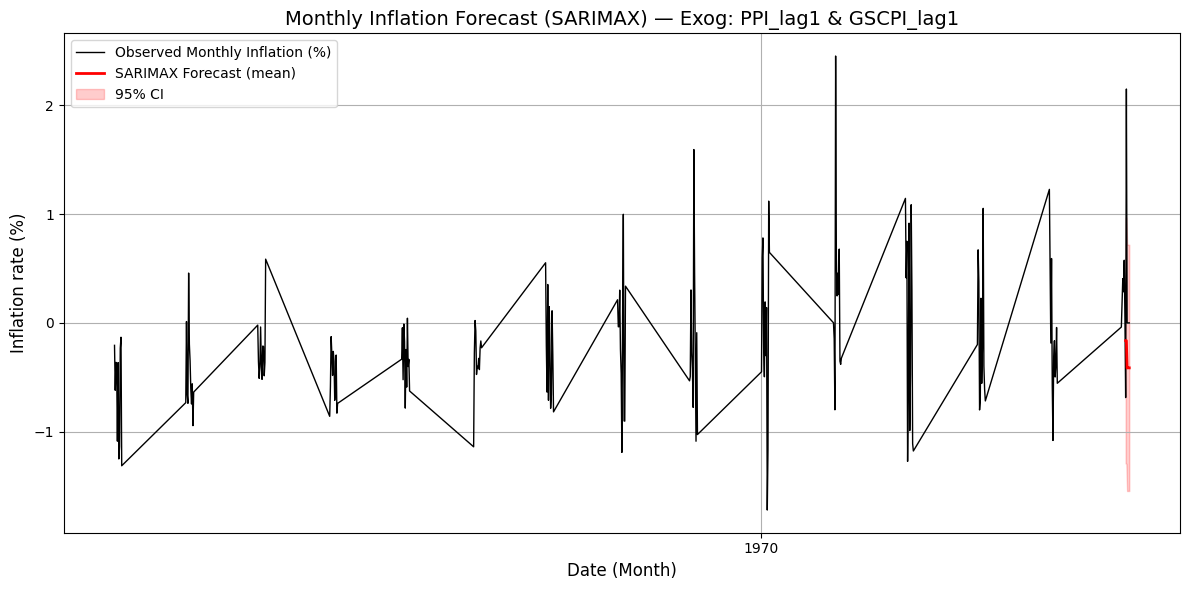

In [123]:
#Code to make plot with labels
plt.figure(figsize=(12,6))
plt.plot(df.index, df['InflationRate'], label='Observed Monthly Inflation (%)', color='black', linewidth=1)
plt.plot(pred_mean.index, pred_mean, label='SARIMAX Forecast (mean)', color='red', linewidth=2)
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='red', alpha=0.2, label='95% CI')

plt.title('Monthly Inflation Forecast (SARIMAX) — Exog: PPI_lag1 & GSCPI_lag1', fontsize=14)
plt.xlabel('Date (Month)', fontsize=12)
plt.ylabel('Inflation rate (%)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [124]:
if 'InflationRate' in test.columns:
    mse = mean_squared_error(test['InflationRate'], pred_mean)
    mae = mean_absolute_error(test['InflationRate'], pred_mean)
    print(f"Test MAE: {mae:.4f}, Test RMSE: {np.sqrt(mse):.4f}")

Test MAE: 0.7478, Test RMSE: 1.0244


In [125]:
# 1) Check scale of your target
print("InflationRate stats:", df['InflationRate'].describe())

# 2) Check baseline error (naive seasonal/last-value)
y_test = df['InflationRate'].iloc[-forecast_steps:]
naive_pred = df['InflationRate'].shift(1).iloc[-forecast_steps:]
print("Naive MAE:", mean_absolute_error(y_test, naive_pred))
print("Naive RMSE:", mean_squared_error(y_test, naive_pred))

InflationRate stats: count    179.000000
mean      -0.207969
std        0.617887
min       -1.718490
25%       -0.587174
50%       -0.295178
75%        0.041300
max        2.451106
Name: InflationRate, dtype: float64
Naive MAE: 0.9512374277035375
Naive RMSE: 2.1952610905524708


In [126]:
df['InflationRate'].describe()
df['InflationRate'].diff().abs().describe()

count    178.000000
mean       0.605585
std        0.563748
min        0.000000
25%        0.196756
50%        0.464785
75%        0.792198
max        3.249145
Name: InflationRate, dtype: float64